# Real Time Classification of Eye Open-Closed State with Machine Learning

## Introduction

Contained herein is the code used to process the EEG data (taken from: https://www.kaggle.com/markwallbang/eeg-eye-state?select=EEG+Eye+State.arff), analyze said data and apply a suite of machine learning algorithms and parameters for the sake of classifying eye-state.

Link to dataset:
- https://www.kaggle.com/markwallbang/eeg-eye-state?select=EEG+Eye+State.arff
- Also at: https://archive.ics.uci.edu/ml/datasets/EEG+Eye+State

Oliver Roesler, it12148 '@' lehre.dhbw-stuttgart.de, Baden-Wuerttemberg Cooperative State University (DHBW), Stuttgart, Germany

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import sklearn as skl
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

from scipy.io import arff
from scipy import signal

In [2]:
data, meta = arff.loadarff('EEG Eye State.arff')
meta

Dataset: EEG_DATA
	AF3's type is numeric
	F7's type is numeric
	F3's type is numeric
	FC5's type is numeric
	T7's type is numeric
	P7's type is numeric
	O1's type is numeric
	O2's type is numeric
	P8's type is numeric
	T8's type is numeric
	FC6's type is numeric
	F4's type is numeric
	F8's type is numeric
	AF4's type is numeric
	eyeDetection's type is nominal, range is ('0', '1')

In [3]:
df = pd.DataFrame(data)

# Casts channels as float values and eye state to just 0 or 1 int
df[df.columns[0:14]] = df[df.columns[0:14]].astype(float)
df.eyeDetection = df.eyeDetection.astype(str)=='b\'1\''
df.eyeDetection = df.eyeDetection.astype(int)

df

,AF3,F7,F3,FC5,T7,P7,O1,O2,P8,T8,FC6,F4,F8,AF4,eyeDetection
0,4329.23,4009.23,4289.23,4148.21,4350.26,4586.15,4096.92,4641.03,4222.05,4238.46,4211.28,4280.51,4635.90,4393.85,0
1,4324.62,4004.62,4293.85,4148.72,4342.05,4586.67,4097.44,4638.97,4210.77,4226.67,4207.69,4279.49,4632.82,4384.10,0
2,4327.69,4006.67,4295.38,4156.41,4336.92,4583.59,4096.92,4630.26,4207.69,4222.05,4206.67,4282.05,4628.72,4389.23,0
3,4328.72,4011.79,4296.41,4155.90,4343.59,4582.56,4097.44,4630.77,4217.44,4235.38,4210.77,4287.69,4632.31,4396.41,0
4,4326.15,4011.79,4292.31,4151.28,4347.69,4586.67,4095.90,4627.69,4210.77,4244.10,4212.82,4288.21,4632.82,4398.46,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14975,4281.03,3990.26,4245.64,4116.92,4333.85,4614.36,4074.87,4625.64,4203.08,4221.54,4171.28,4269.23,4593.33,4340.51,1
14976,4276.92,3991.79,4245.13,4110.77,4332.82,4615.38,4073.33,4621.54,4194.36,4217.44,4162.56,4259.49,4590.26,4333.33,1
14977,4277.44,3990.77,4246.67,4113.85,4333.33,4615.38,4072.82,4623.59,4193.33,4212.82,4160.51,4257.95,4591.79,4339.49,1
14978,4284.62,3991.79,4251.28,4122.05,4334.36,4616.41,4080.51,4628.72,4200.00,4220.00,4165.64,4267.18,4596.41,4350.77,1


Here, the sampling rate of the data $\textit{fs}=128\text{ Hz}$, and the total duration $T=14980$ samples, approximately 117 seconds (117013.25 ms)

Since *fs* equals the number of samples contained in 1 second, it'll be used to represent 1 second worth of samples in the code.

In [4]:
fs = 128
T = df.shape[0]

Here is a summary of the dataframe containing the entirety of the data

In [5]:
stat = df.describe().transpose()
stat

,count,mean,std,min,25%,50%,75%,max
AF3,14980.0,4321.917777,2492.072174,1030.7700,4280.51,4294.36,4311.79,309231.00
F7,14980.0,4009.767694,45.941672,2830.7700,3990.77,4005.64,4023.08,7804.62
F3,14980.0,4264.022433,44.428052,1040.0000,4250.26,4262.56,4270.77,6880.51
FC5,14980.0,4164.946326,5216.404632,2453.3300,4108.21,4120.51,4132.31,642564.00
T7,14980.0,4341.741075,34.738821,2089.7400,4331.79,4338.97,4347.18,6474.36
P7,14980.0,4644.022379,2924.789537,2768.2100,4611.79,4617.95,4626.67,362564.00
O1,14980.0,4110.400160,4600.926543,2086.1500,4057.95,4070.26,4083.59,567179.00
O2,14980.0,4616.056904,29.292603,4567.1800,4604.62,4613.33,4624.10,7264.10
P8,14980.0,4218.826610,2136.408523,1357.9500,4190.77,4199.49,4209.23,265641.00
T8,14980.0,4231.316200,38.050903,1816.4100,4220.51,4229.23,4239.49,6674.36


The statistics indicate that there are some extreme outlier values in the data, we'll iterate over the data a few times to remove these values and interpolate an estimate value to take their place.

$$\mathbf{x}_i'=\left\{\begin{matrix}\frac{1}{2}(\mathbf{x}_{i-1}-\mathbf{x}_{i+1}),&|\mathbf{x}_i-\mu|>10\sigma\\ \mathbf{x}_i,& \textit{otherwise}\end{matrix}\right.$$

where $\sigma$ is the standard deviation.

In [6]:
changes = 0

for a in range(2):
    stat=df.describe()
    for c in df.columns[0:14]:
        for i in range(0,df.shape[0]):
            if abs(df.loc[i,c]-stat.loc['mean',c])/stat.loc['std',c] > 10.0:
                df.at[i,c] = df.loc[(i-1,i+1),c].mean()
                changes += 1
                
print('Total changes: {}'.format(changes))

Total changes: 54


Since these changes affect less than $0.5\%$ of the data, it can be assumed this will have a negligible impact on the results.

Plotted below is the raw data from each EEG channel

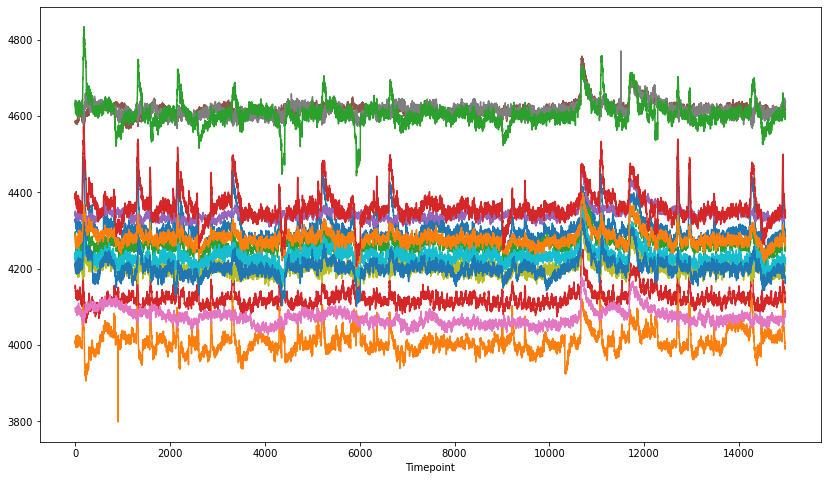

In [7]:
plt.figure(figsize=(14,8))
for i in df.columns[0:14]:
    plt.plot(df[i])
plt.xlabel('Timepoint')
plt.show()

I'd like to look at the EEG data in the frequency domain ( $\textit{fs}_{\textit{Nyquist}}=64\text{ Hz}$)

In [8]:
# Frequency domain of the data
f = np.arange(0,128,128/df.shape[0])

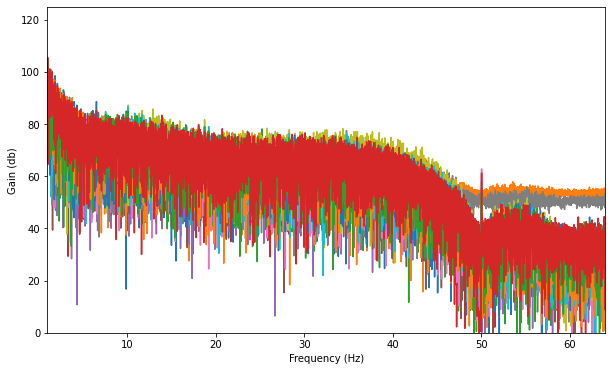

In [9]:
plt.figure(figsize=(10,6))
for i in df.columns[0:14]:
    plt.plot(f, 10*np.log(abs(sp.fft.fft(df[i].to_numpy()))))
plt.xlim(1,64)
plt.ylim(0,125)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Gain (db)')
plt.savefig('Images/freq_dom.png')
plt.show()

Here, there appears to be a power spike at 50 Hz, I would like to remove this spike so I'll design a notch filter.

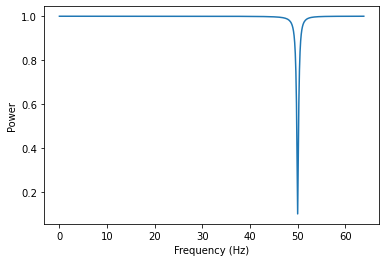

In [10]:
b, a = signal.iirnotch(50.0, 75.0, 128)
freq, h = signal.freqz(b, a, fs=128)
h = 0.9*h+0.1
plt.plot(freq,abs(h))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.show()

I'll then convolve the filter with the data (product in the frequency domain)

In [11]:
h1= np.linspace(1,1,14980)
h2= np.hstack((h, np.flip(h)))
for i in range(0,14980):
    h1[i] = h2[int(i*1024/14980)]

<ipython-input-11-c5f35307dc55>:4: ComplexWarning: Casting complex values to real discards the imaginary part
  h1[i] = h2[int(i*1024/14980)]


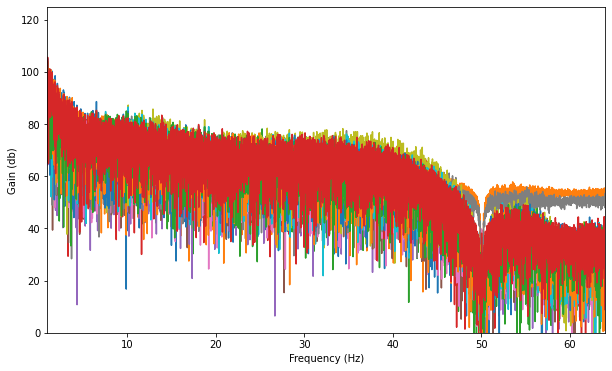

In [12]:
plt.figure(figsize=(10,6))
for i in df.columns[0:14]:
    y1 = h1*sp.fft.fft(df[i].to_numpy())
    plt.plot(f,10*np.log(abs(y1)))
    df[i] = abs(sp.fft.ifft(y1))
plt.xlim(1,64)
plt.ylim(0,125)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Gain (db)')
plt.show()

Now that the 50 Hz signal has been mostly suppressed, I'll plot again the EEG data.

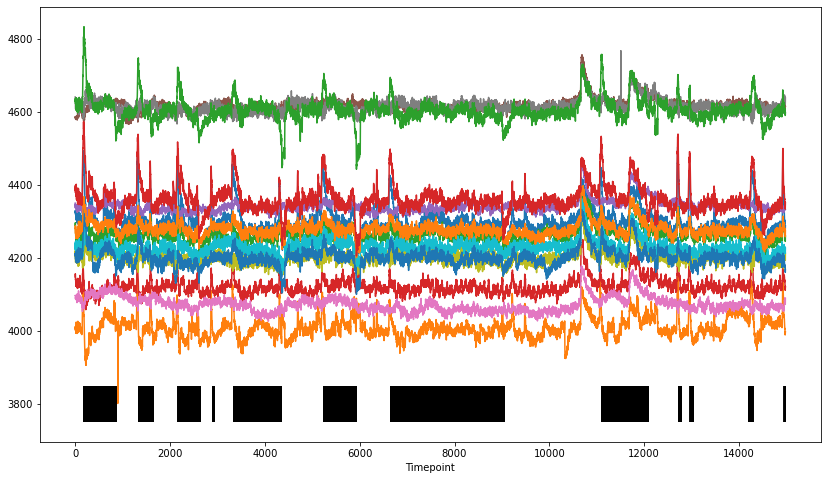

In [13]:
plt.figure(figsize=(14,8))
for i in df.columns[0:14]:
    plt.plot(df[i])
plt.vlines(list(df[df.eyeDetection==1].index), 3750, 3850)
plt.xlabel('Timepoint')
plt.savefig('Images/filtered_signal.png')

Displayed below the data is a representation of the eye-state across the time domain. The black regions correspond to intervals of time where $\text{eye-state}=1$ or eyes are closed. 

Based on visual inspection, it would seem that there is a noticable upward spike each time the eye-state transitions from open (0) to closed (1). This should come in handy for later, but we'll first produce a correlation heatmap to check if there may be any relationships between channels and/or the eye-state label.

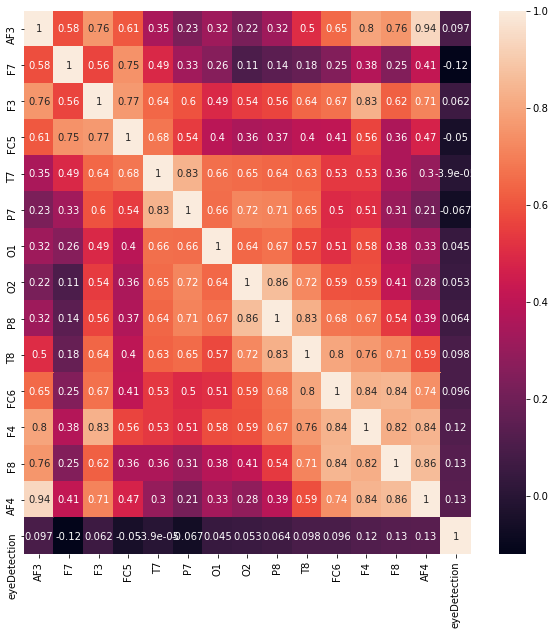

In [14]:
corr = df.corr(method='pearson')
plt.figure(figsize=(10,10))
sns.heatmap(corr, annot=True)
plt.savefig('Images/corr_heatmap.png')
plt.show()

Judging by the correlation heatmap it would seem that no single value at any particular channel reliably correlates with eye-state.

In [15]:
def eye_state_plot(pred, split, model='', params=''):
    plt.figure(figsize=(18,5))
    truth = np.array(df.eyeDetection)[fs:]
    
    plt.vlines(np.where(truth==1), 1.2, 2.0)
    plt.vlines(np.where(pred==1), 0.0, 0.8, 'blue')
    
    correct = np.equal(truth, pred)
    plt.vlines(np.where(correct==1), 0.9, 1.1, 'green')
    plt.vlines(np.where(correct==0), 0.9, 1.1, 'red')
    
    plt.vlines(split, 0, 2, 'grey','dashed')
    
    plt.yticks([0.4, 1.0, 1.6], ['Predicted','Correctness', 'Truth'])
    plt.savefig('Images/{}_{}_{}_eye_state.png'.format(model,params,split))
    plt.show()

$$\text{Rolling average at }n=\frac{1}{128}\sum_{i=1}^{128}\left\{\begin{matrix}\mathbf{y}_{n-i},&n-i<\text{split}\\ \mathbf{\hat{y}}_{n-i},&n-i\geq\text{split} \end{matrix}\right.$$

where $\mathbf{y}$ denotes the truth values, $\mathbf{\hat{y}}$ denotes the predicted label and $n$ is the time point.

The first 128 points are cut-off from each variant of the data for the sake of consistency. 

In [16]:
X_and_Y = []
for i in range(fs,T):
    X_and_Y.append(df[i-fs:i].to_numpy()[:,:-1].ravel())
X_and_Y= np.array(X_and_Y)
means = np.array([df.eyeDetection[i-fs:i].mean() for i in range(fs,T)])

X_and_Y2 = np.hstack((X_and_Y, df.eyeDetection[fs:].to_numpy().reshape(-1,1)))

X_and_Y= np.hstack((X_and_Y, means.reshape(-1,1)))
X_and_Y= np.hstack((X_and_Y, df.eyeDetection[fs:].to_numpy().reshape(-1,1)))

#X_and_Y3 = df.to_numpy()[fs:]

## Main Algorithms

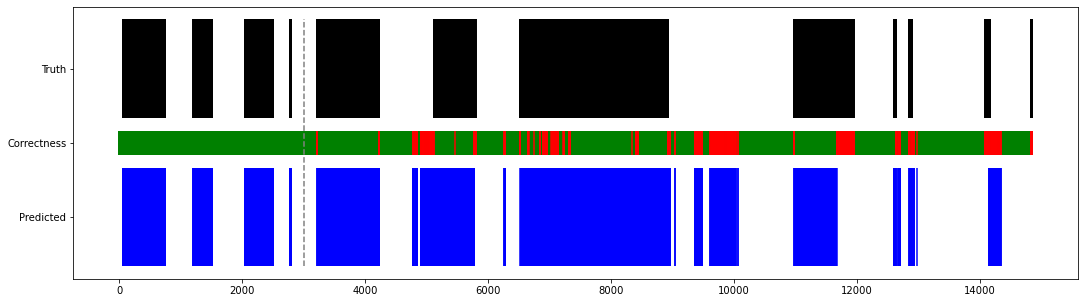

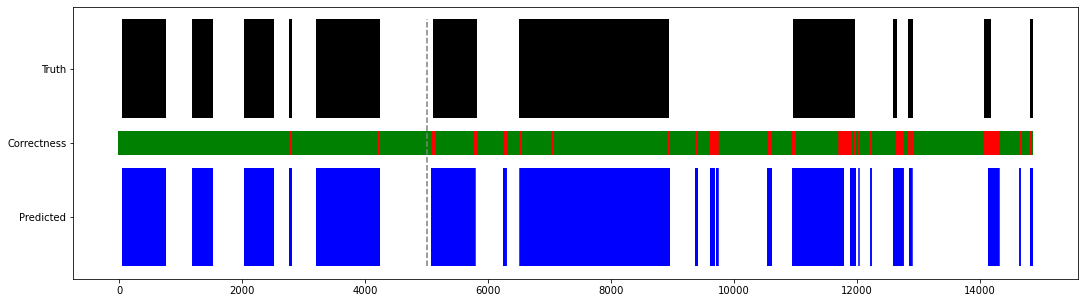

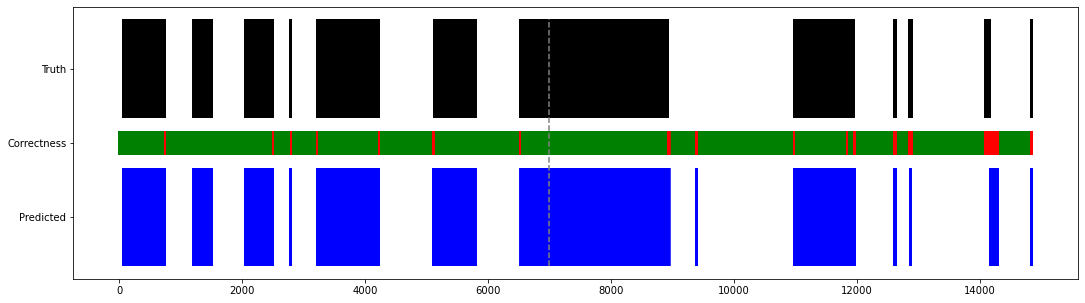

In [17]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

X = X_and_Y[:,:-1]
Y = X_and_Y[:,-1]
results = []

for split in [3000, 5000, 7000]:

    clf = LinearDiscriminantAnalysis()

    clf.fit(X[:split],Y[:split])

    Y_pred = Y.copy()
    X_pred = X.copy()

    for i in range(split,T-fs):
        Y_pred[i] = clf.predict(X_pred[i].reshape(1,-1))
        X_pred[i,-1] = Y_pred[i-fs:i].mean()

    result = clf.score(X_pred[split:],Y[split:])
    results.append([split, result])

    eye_state_plot(clf.predict(X_pred),split, 'LDA', '+preds')
    
pd1 = pd.DataFrame(results, columns=['split', 'accuracy'])

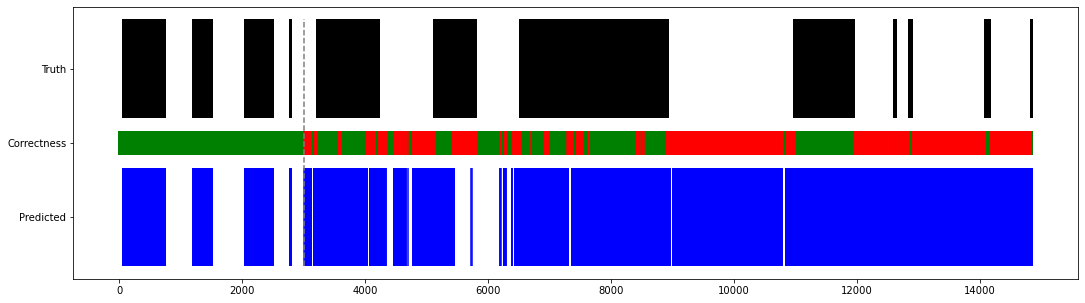

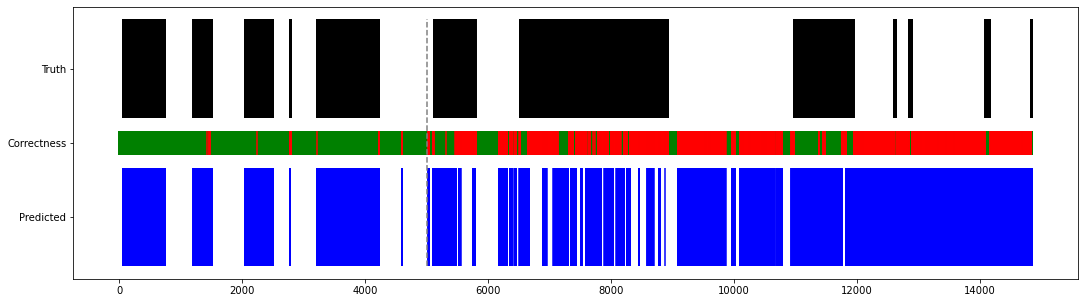

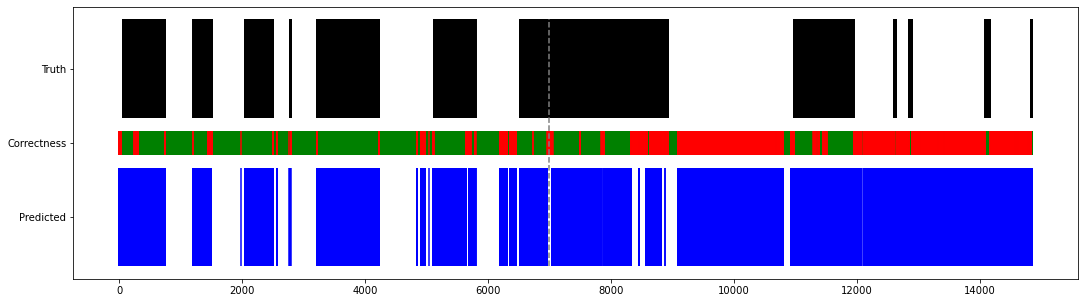

In [18]:
X = X_and_Y2[:,:-1]
Y = X_and_Y2[:,-1]
results = []

for split in [3000,5000,7000]:
    clf = LinearDiscriminantAnalysis()

    clf.fit(X[:split],Y[:split])
    
    result = clf.score(X[split:],Y[split:])
    results.append([split, result])
    
    eye_state_plot(clf.predict(X),split, 'LDA', '-preds')
    
pd2 = pd.DataFrame(results, columns=['split', 'accuracy'])

In [19]:
pd3 = pd.DataFrame(pd1['split'])
pd3['accuracy (w/ preds)'] = pd1['accuracy']
pd3['accuracy (w/o preds)'] = pd2['accuracy']
pd3

,split,accuracy (w/ preds),accuracy (w/o preds)
0,3000,0.869558,0.496372
1,5000,0.932298,0.385099
2,7000,0.959373,0.376210


C:\Users\andre\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


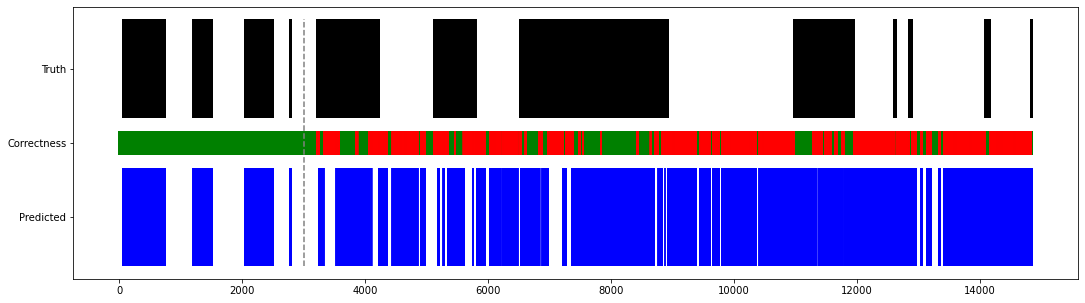

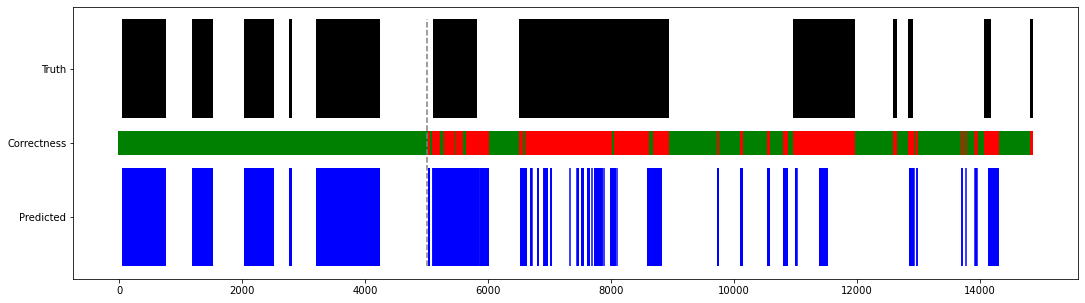

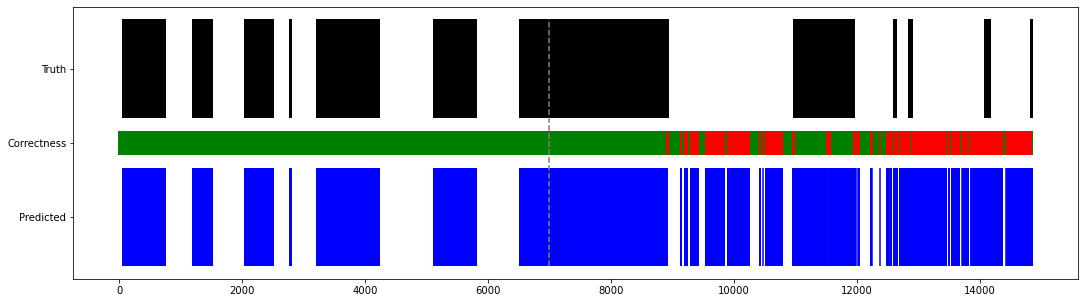

In [20]:
X = X_and_Y[:,:-1]
Y = X_and_Y[:,-1]
results = []

for split in [3000,5000,7000]:
    
    clf = QuadraticDiscriminantAnalysis()
    clf.fit(X[:split],Y[:split])

    Y_pred = Y.copy()
    X_pred = X.copy()

    for i in range(split,T-fs):
        Y_pred[i] = clf.predict(X_pred[i].reshape(1,-1))
        X_pred[i,-1] = Y_pred[i-fs:i].mean()

    result = clf.score(X_pred[split:],Y[split:])
    results.append([split, result])
    
    eye_state_plot(clf.predict(X_pred),split, 'QDA', '+preds')
    
pd1 = pd.DataFrame(results, columns=['split', 'accuracy'])

C:\Users\andre\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


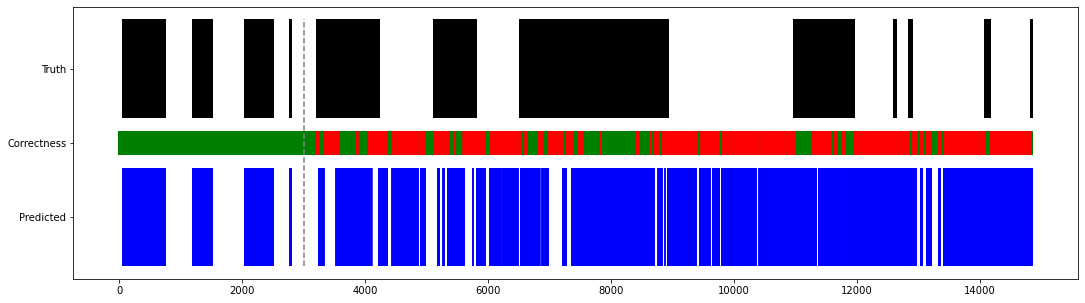

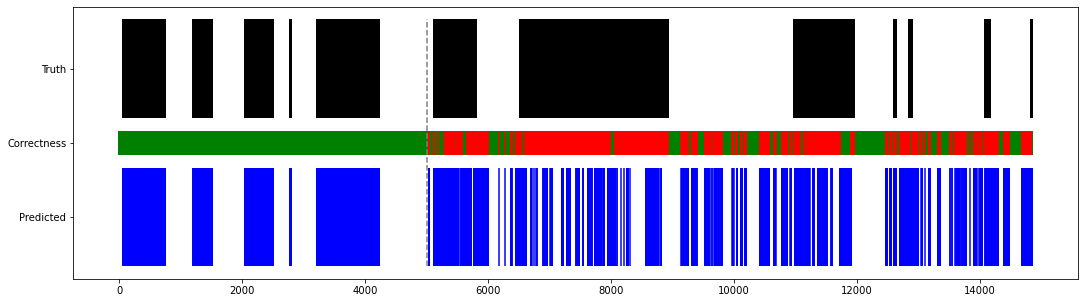

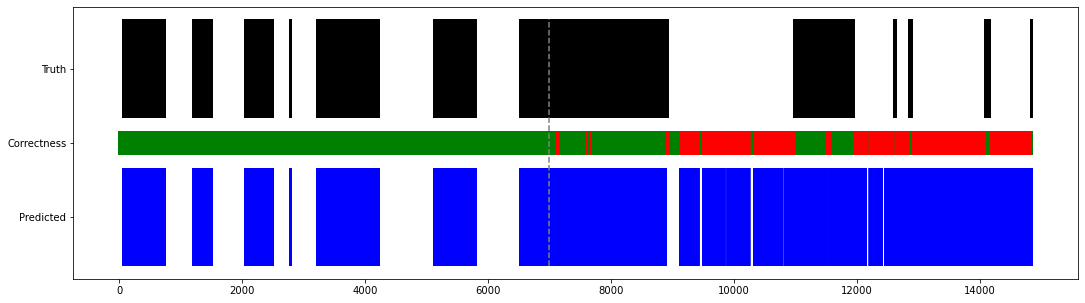

In [21]:
X = X_and_Y2[:,:-1]
Y = X_and_Y2[:,-1]
results = []

for split in [3000,5000,7000]:
    clf = QuadraticDiscriminantAnalysis()

    clf.fit(X[:split],Y[:split])

    result = clf.score(X[split:],Y[split:])
    results.append([split, result])
    
    eye_state_plot(clf.predict(X),split, 'QDA', '-preds')
    
pd2 = pd.DataFrame(results, columns=['split', 'accuracy'])

In [22]:
pd3 = pd.DataFrame(pd1['split'])
pd3['accuracy (w/ preds)'] = pd1['accuracy']
pd3['accuracy (w/o preds)'] = pd2['accuracy']
pd3

,split,accuracy (w/ preds),accuracy (w/o preds)
0,3000,0.444566,0.444482
1,5000,0.644336,0.618352
2,7000,0.660341,0.497580


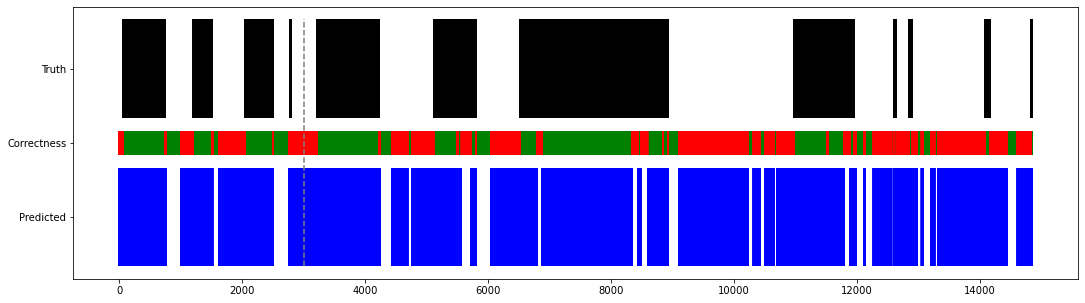

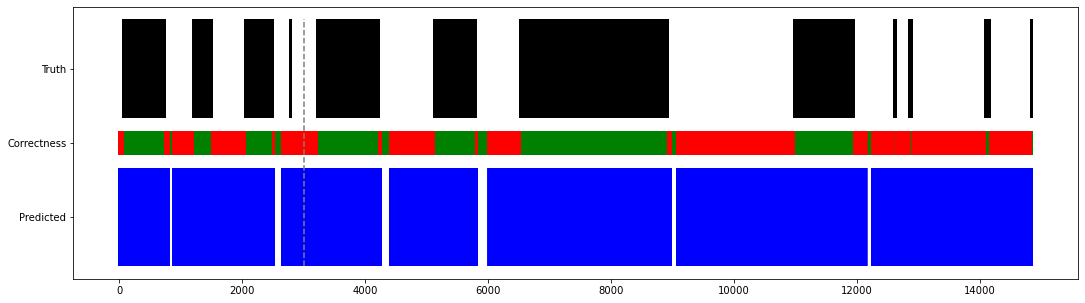

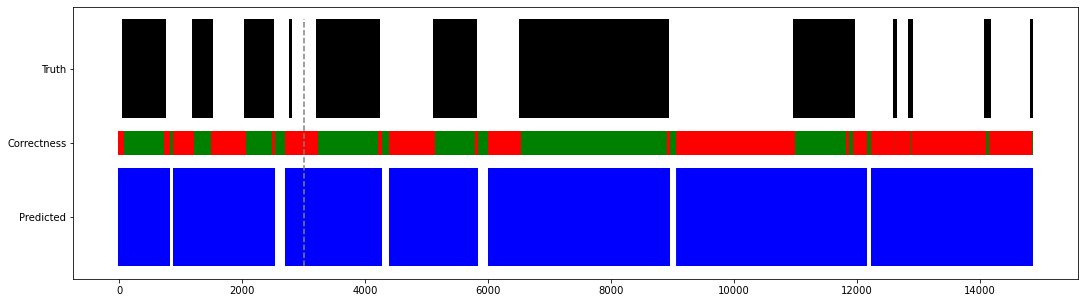

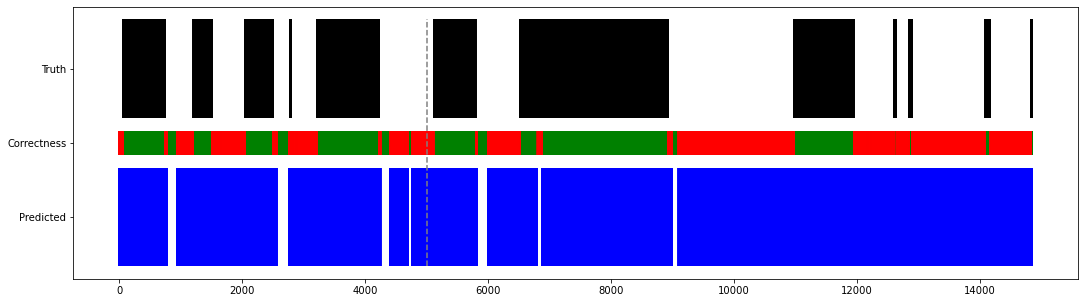

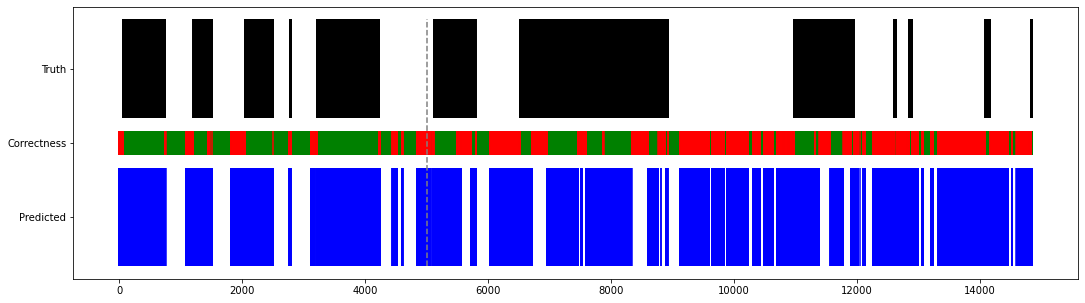

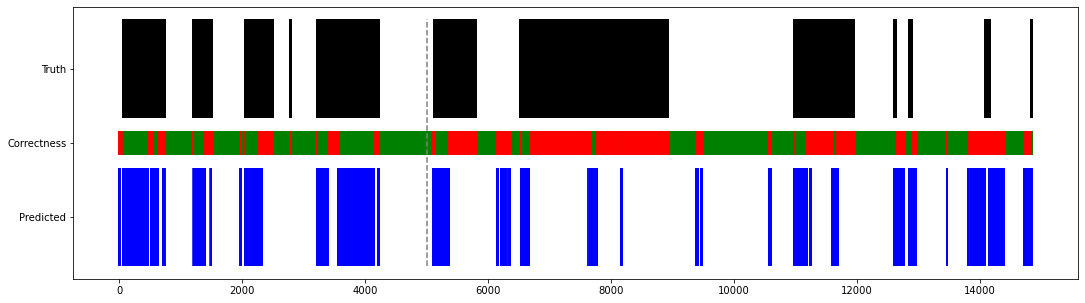

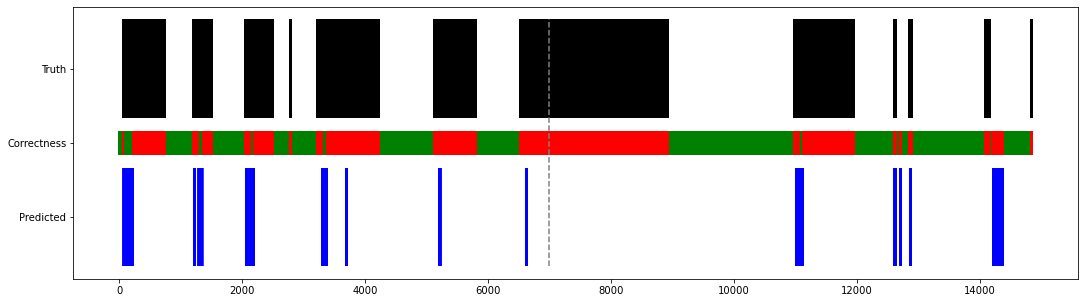

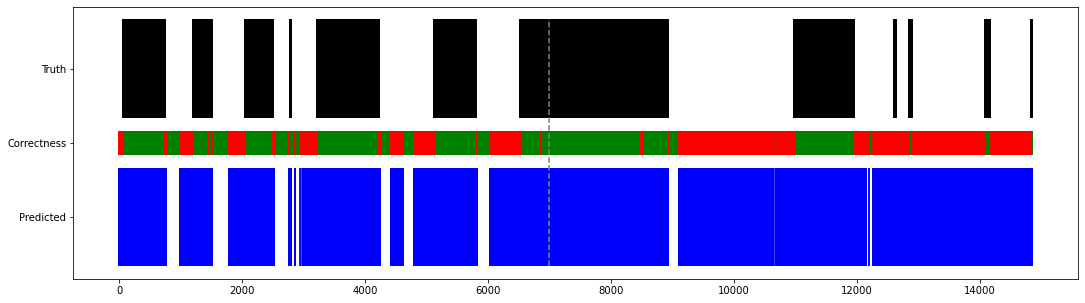

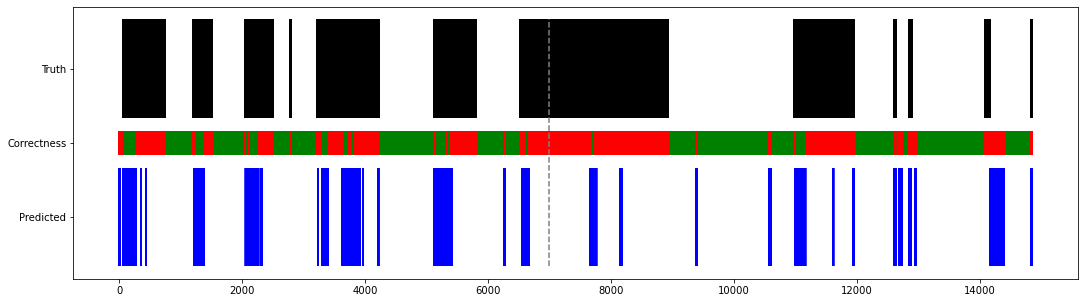

In [23]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

from sklearn.svm import LinearSVC

X = X_and_Y[:,:-1]
Y = X_and_Y[:,-1]
results = []

for split in [3000,5000,7000]:
    for c in [0.5,1.0,5.0]:
        clf = LinearSVC(C=c)
        clf.fit(X[:split],Y[:split])

        Y_pred = Y.copy()
        X_pred = X.copy()

        for i in range(split,T-fs):
            Y_pred[i] = clf.predict(X_pred[i].reshape(1,-1))
            X_pred[i,-1] = Y_pred[i-fs:i].mean()

        result = clf.score(X_pred[split:],Y[split:])
        results.append([split, c, result])
        
        eye_state_plot(clf.predict(X_pred),split, 'SVC', 'c={}_+preds'.format(c))
        
pd1 = pd.DataFrame(results, columns=['split', 'C', 'accuracy'])

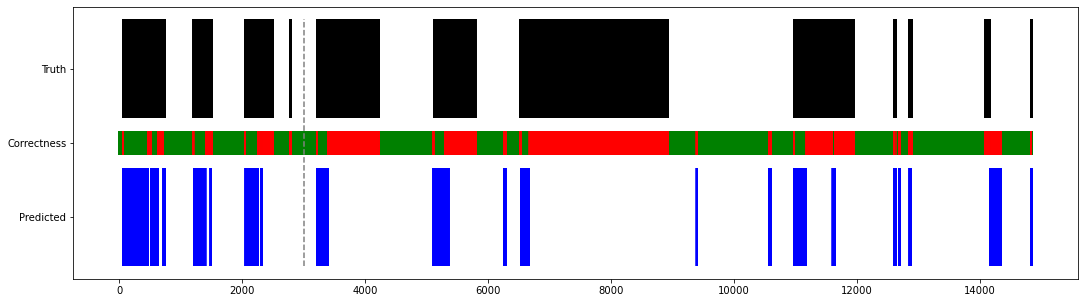

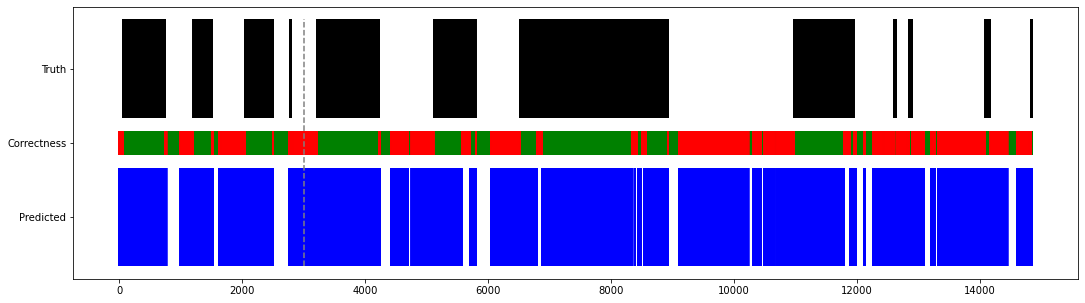

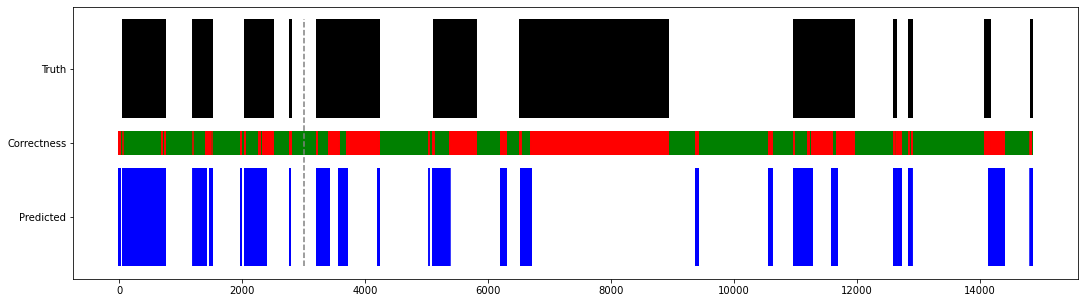

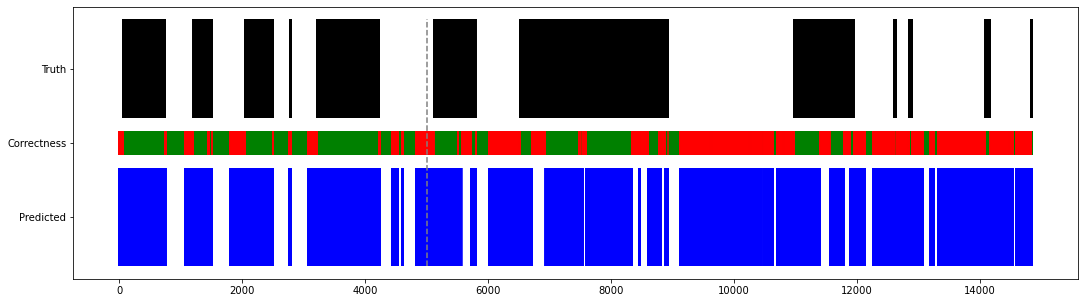

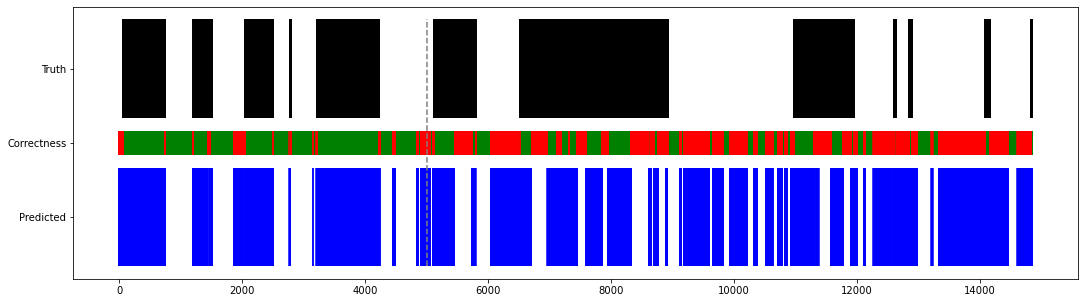

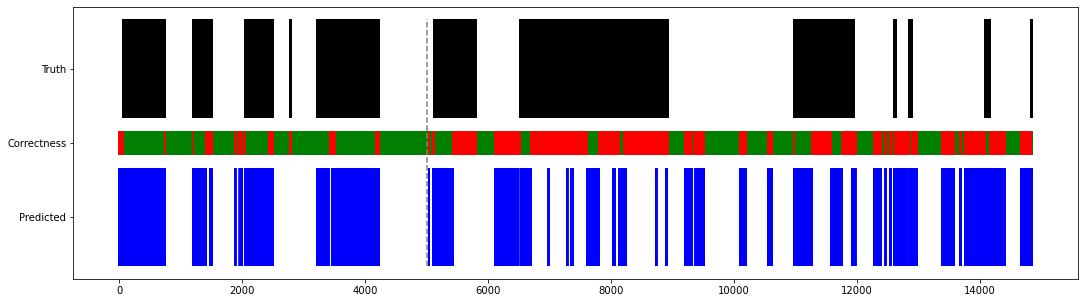

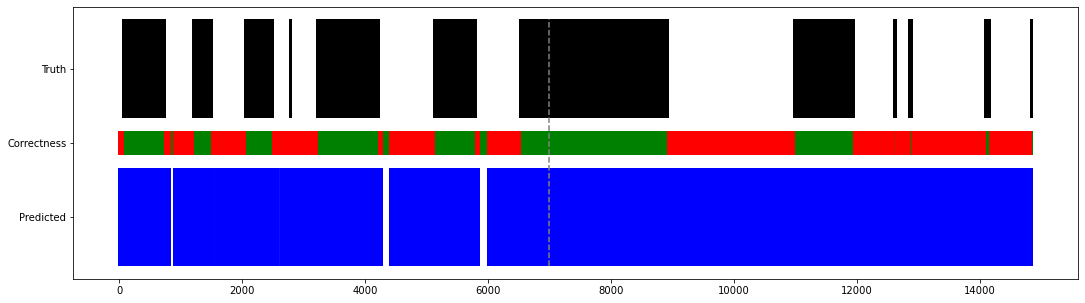

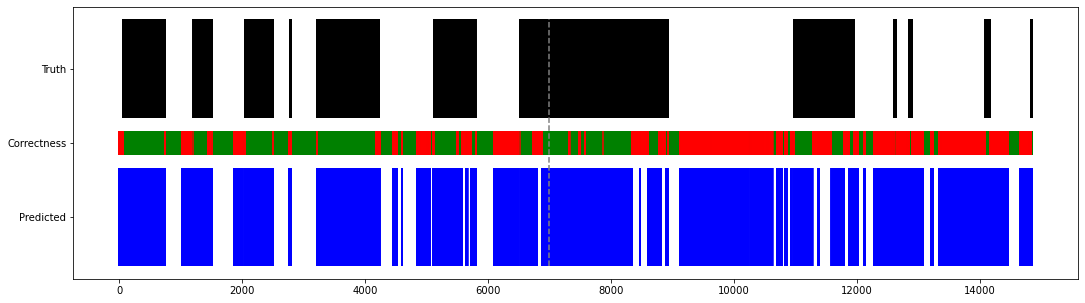

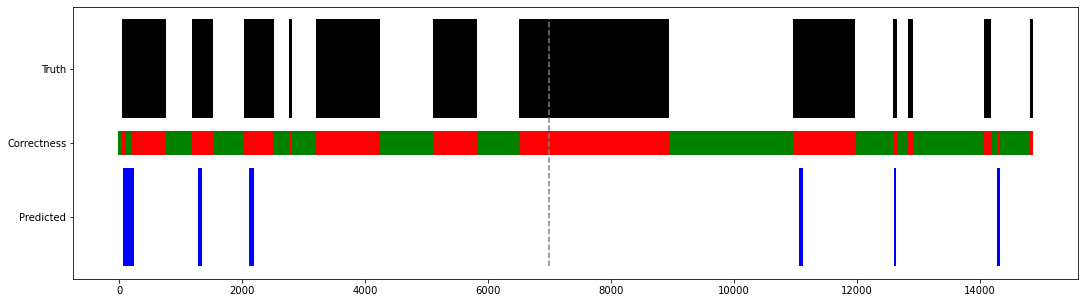

In [24]:
X = X_and_Y2[:,:-1]
Y = X_and_Y2[:,-1]
results = []

for split in [3000,5000,7000]:
    for c in [0.5,1.0,5.0]:
        clf = LinearSVC(C=c)
        clf.fit(X[:split],Y[:split])

        result = clf.score(X[split:],Y[split:])
        results.append([split, c, result])
        
        eye_state_plot(clf.predict(X),split, 'SVC', 'c={}_-preds'.format(c))
        
pd2 = pd.DataFrame(results, columns=['split', 'C', 'accuracy'])

In [25]:
pd3 = pd1[['split','C']]
pd3['accuracy (w/ preds)'] = pd1['accuracy']
pd3['accuracy (w/o preds)'] = pd2['accuracy']
pd3

,split,C,accuracy (w/ preds),accuracy (w/o preds)
0,3000,0.5,0.540162,0.605636
1,3000,1.0,0.486247,0.526325
2,3000,5.0,0.494684,0.624789
3,5000,0.5,0.456557,0.438490
4,5000,1.0,0.456354,0.476959
5,5000,5.0,0.576431,0.515631
6,7000,0.5,0.607998,0.395059
7,7000,1.0,0.450331,0.460010
8,7000,5.0,0.610800,0.610036


100%|███████████████████████████████████████████████████████████████████████████| 11852/11852 [01:25<00:00, 137.91it/s]


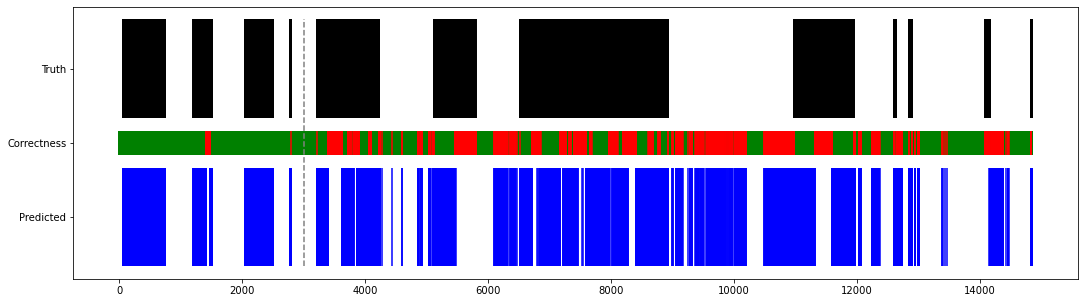

100%|███████████████████████████████████████████████████████████████████████████| 11852/11852 [01:16<00:00, 154.58it/s]


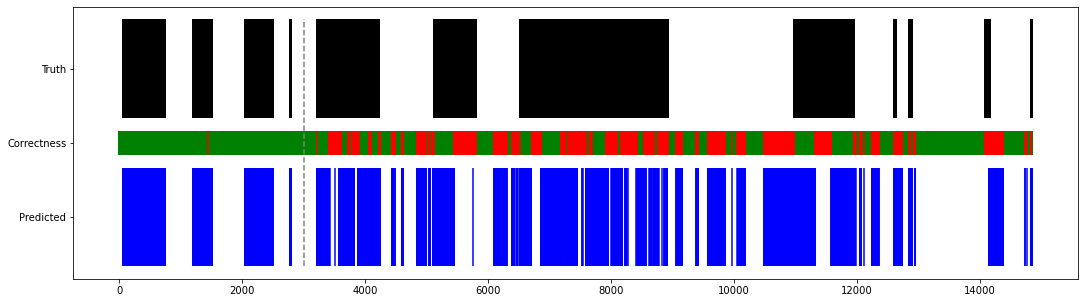

100%|███████████████████████████████████████████████████████████████████████████| 11852/11852 [01:16<00:00, 155.42it/s]


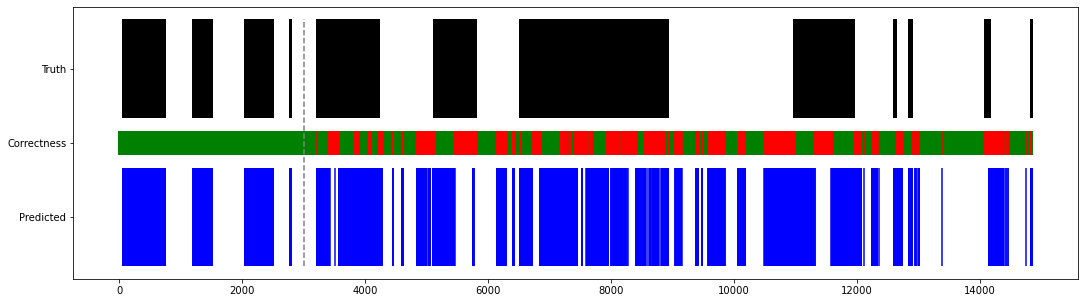

100%|███████████████████████████████████████████████████████████████████████████| 11852/11852 [01:17<00:00, 153.39it/s]


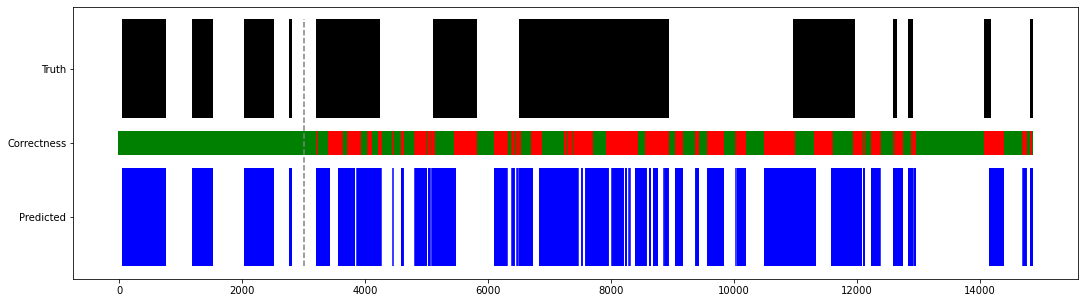

100%|█████████████████████████████████████████████████████████████████████████████| 9852/9852 [01:03<00:00, 154.19it/s]


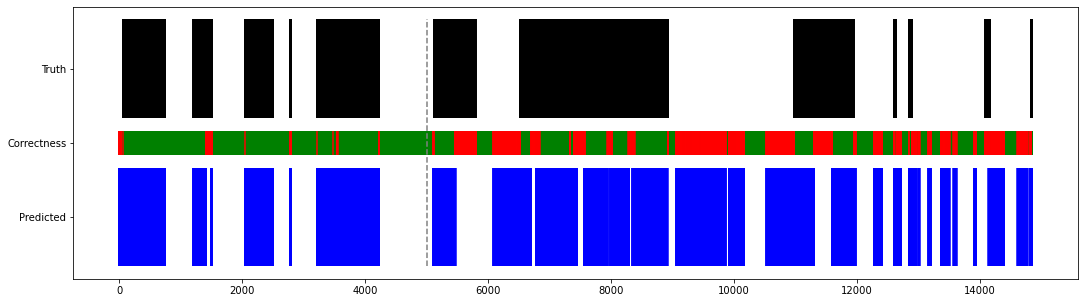

100%|█████████████████████████████████████████████████████████████████████████████| 9852/9852 [01:04<00:00, 151.63it/s]


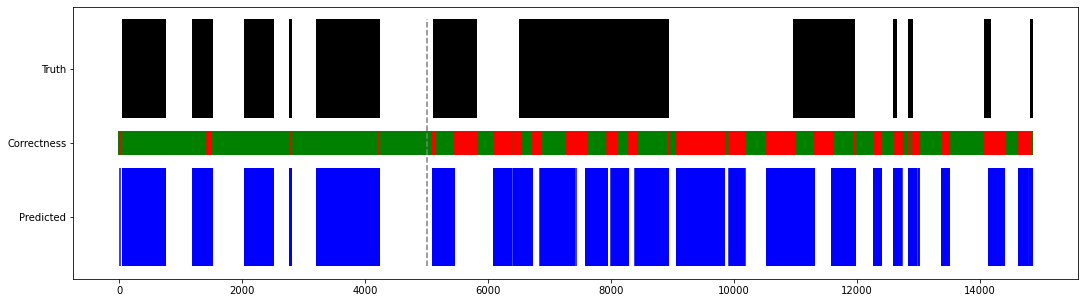

100%|█████████████████████████████████████████████████████████████████████████████| 9852/9852 [01:06<00:00, 147.63it/s]


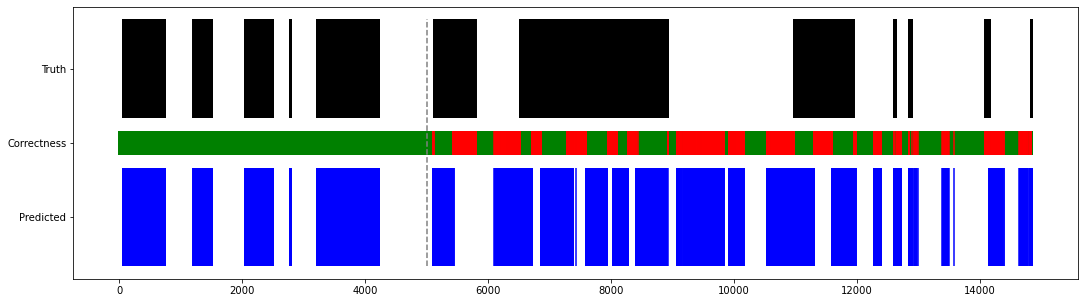

100%|█████████████████████████████████████████████████████████████████████████████| 9852/9852 [01:05<00:00, 151.48it/s]


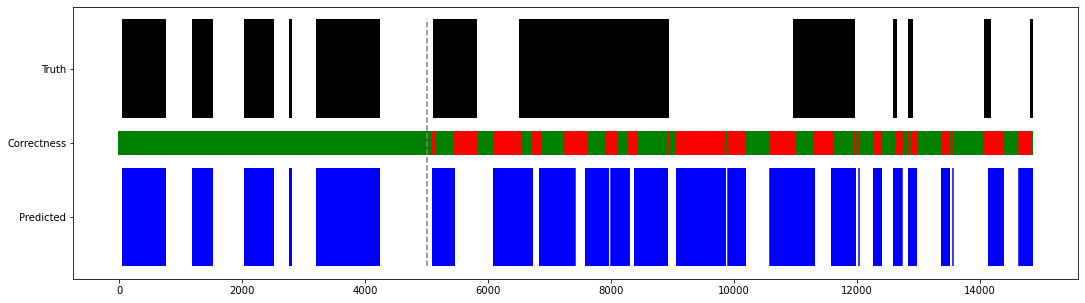

100%|█████████████████████████████████████████████████████████████████████████████| 7852/7852 [00:51<00:00, 151.80it/s]


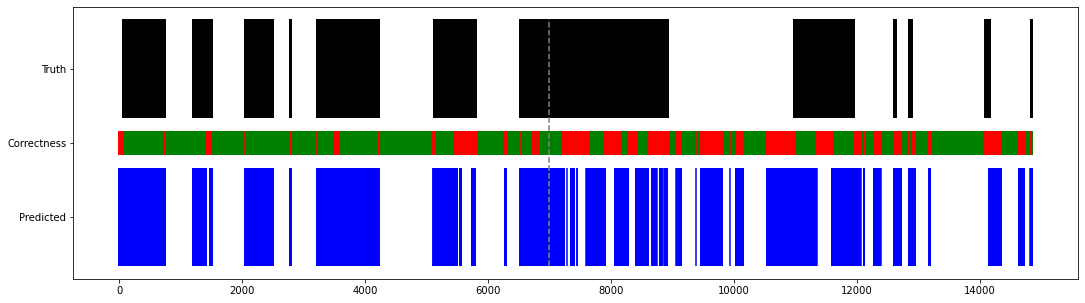

100%|█████████████████████████████████████████████████████████████████████████████| 7852/7852 [00:52<00:00, 150.33it/s]


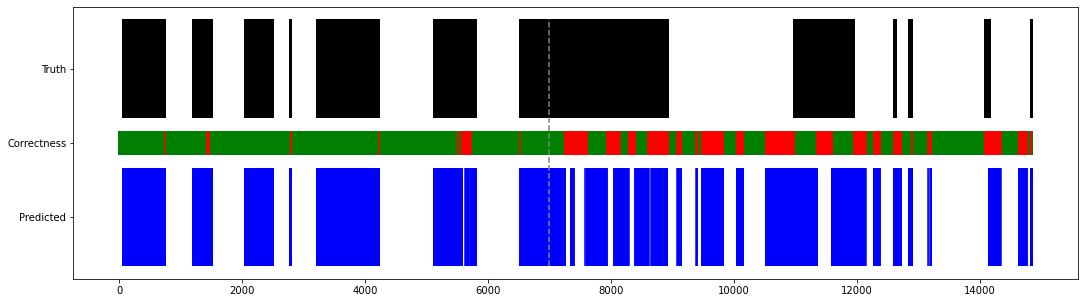

100%|█████████████████████████████████████████████████████████████████████████████| 7852/7852 [00:51<00:00, 152.30it/s]


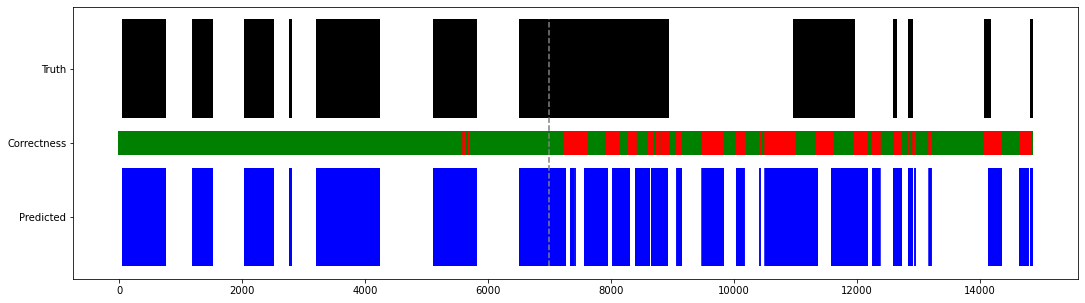

100%|█████████████████████████████████████████████████████████████████████████████| 7852/7852 [00:52<00:00, 149.01it/s]


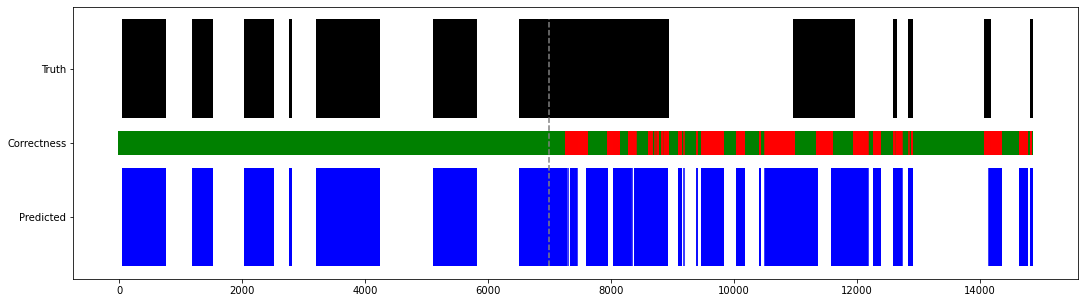

In [26]:
from sklearn.ensemble import RandomForestClassifier

X = X_and_Y[:,:-1]
Y = X_and_Y[:,-1]
results = []

for split in [3000,5000,7000]:
    for depth in [4,6,8,10]:
        clf = RandomForestClassifier(max_depth = depth)
        clf.fit(X[:split],Y[:split])

        Y_pred = Y.copy()
        X_pred = X.copy()

        for i in tqdm(range(split,T-fs)):
            Y_pred[i] = clf.predict(X_pred[i].reshape(1,-1))
            X_pred[i,-1] = Y_pred[i-fs:i].mean()

        result = clf.score(X_pred[split:],Y[split:])
        results.append([split, depth, result])

        eye_state_plot(clf.predict(X_pred),split, 'RF', 'd={}_+preds'.format(depth))
        
pd1 = pd.DataFrame(results, columns=['split', 'depth', 'accuracy'])

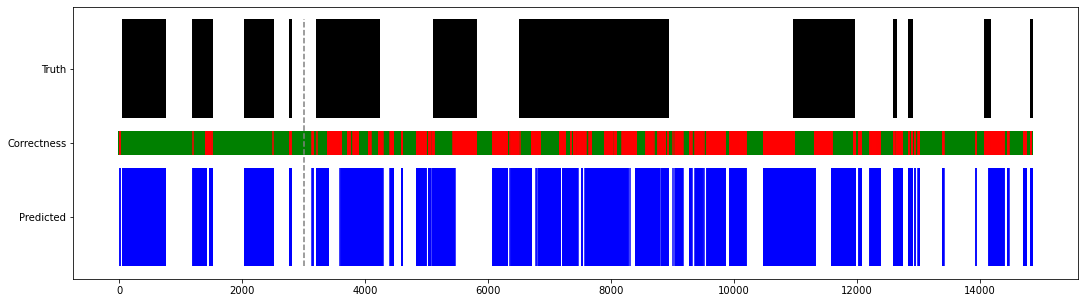

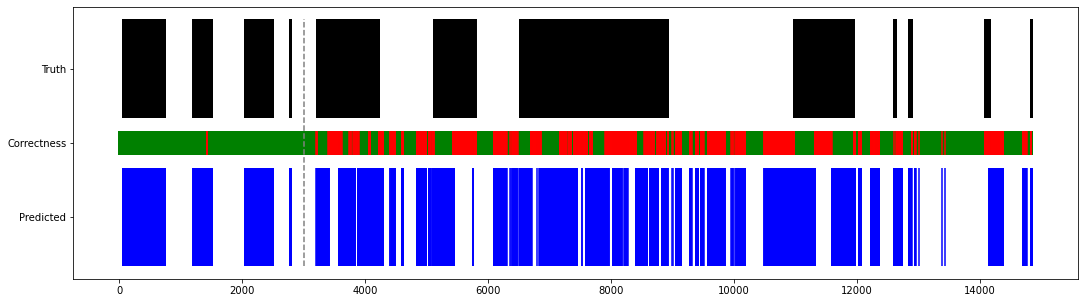

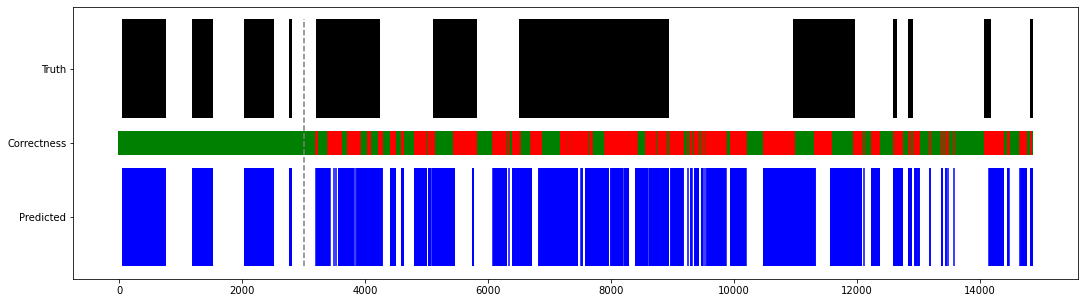

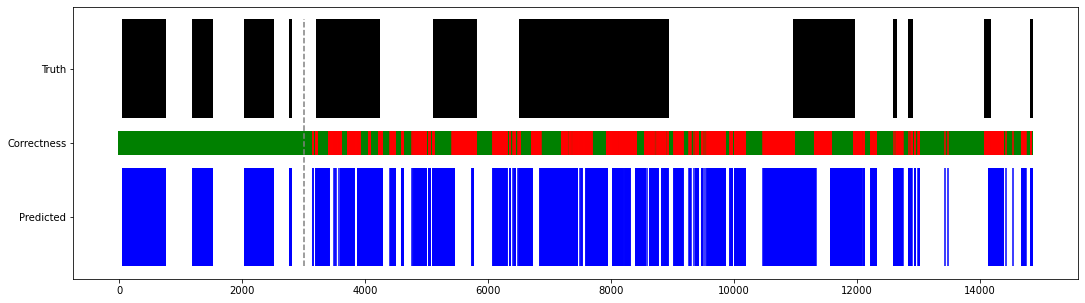

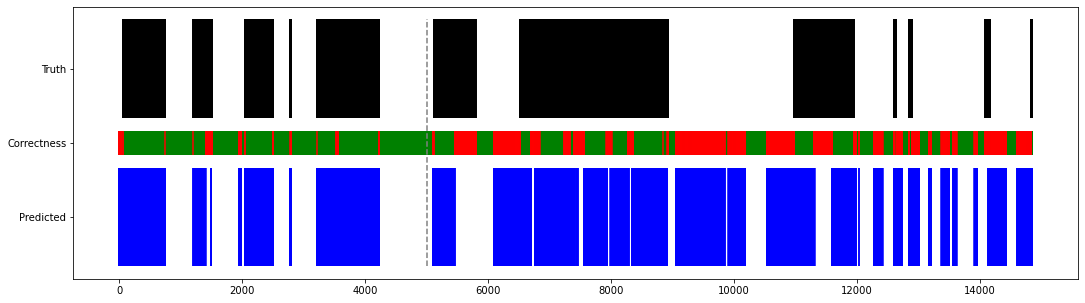

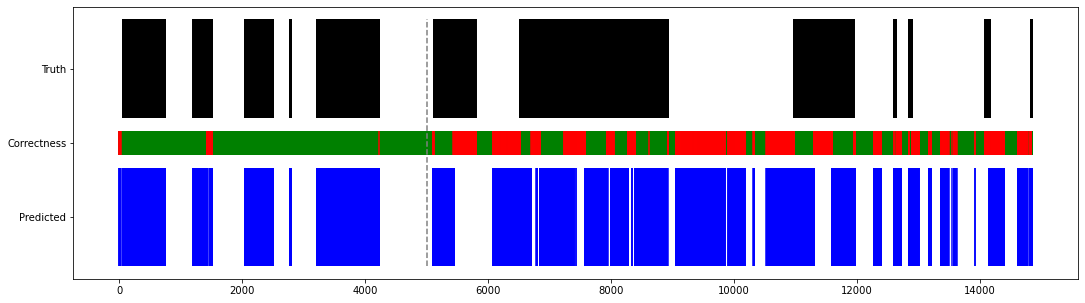

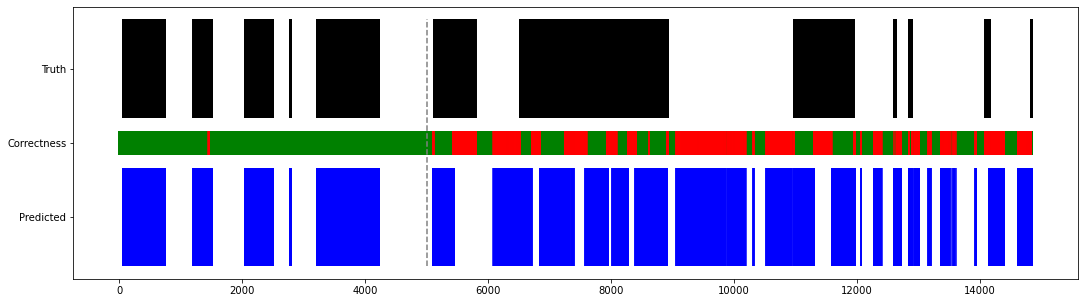

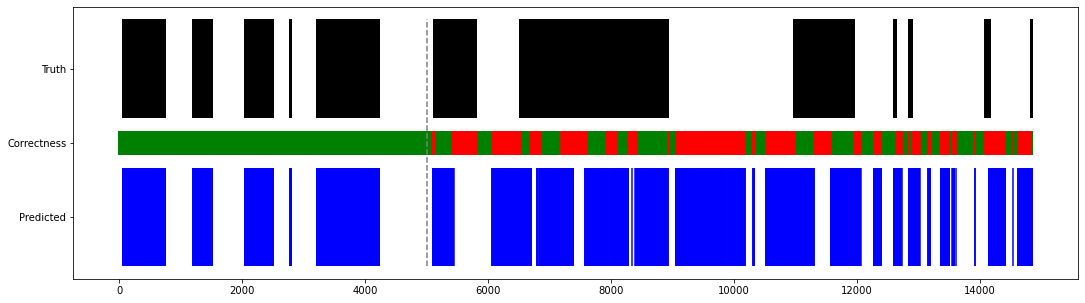

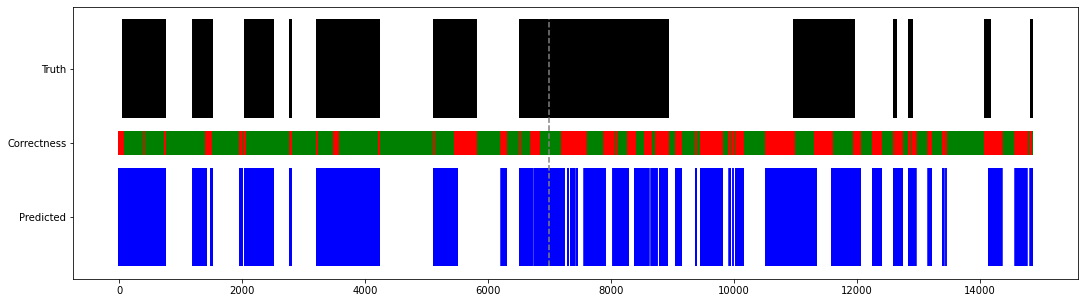

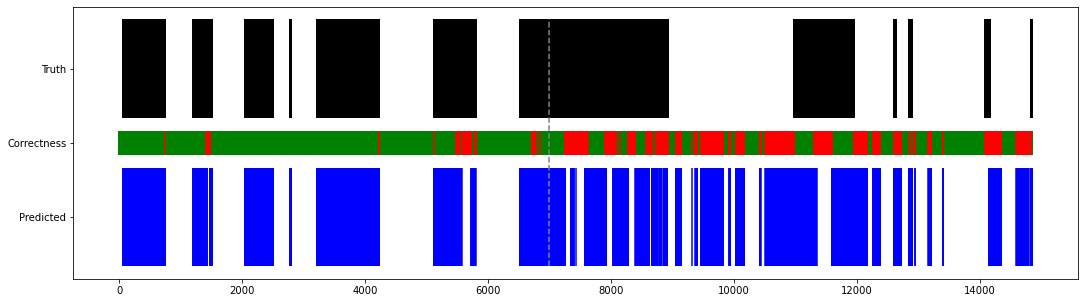

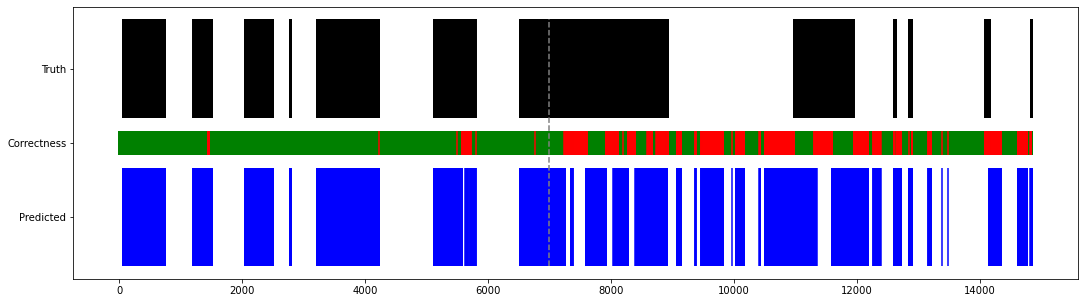

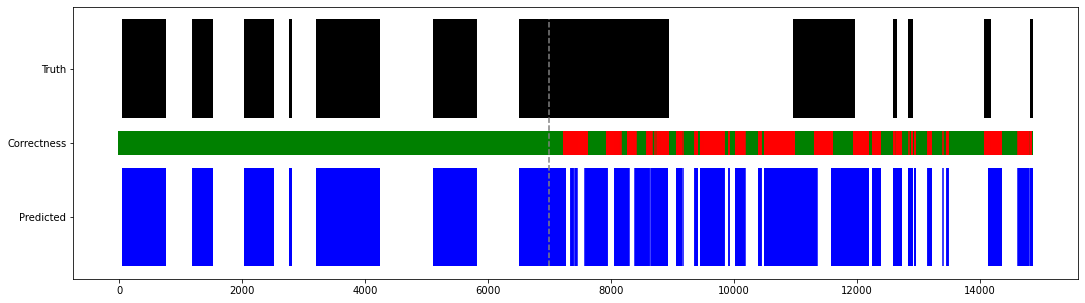

In [27]:
X = X_and_Y2[:,:-1]
Y = X_and_Y2[:,-1]
results = []

for split in [3000,5000,7000]:
    for depth in [4,6,8,10]:
        clf = RandomForestClassifier(max_depth = depth)
        clf.fit(X[:split],Y[:split])

        result = clf.score(X[split:],Y[split:])
        results.append([split, depth, result])

        eye_state_plot(clf.predict(X),split, 'RF', 'd={}_-preds'.format(depth))
        
pd2 = pd.DataFrame(results, columns=['split', 'depth', 'accuracy'])

In [29]:
pd3 = pd1[['split','depth']]
pd3['accuracy (w/ preds)'] = pd1['accuracy']
pd3['accuracy (w/o preds)'] = pd2['accuracy']
pd3

,split,depth,accuracy (w/ preds),accuracy (w/o preds)
0,3000,4,0.694735,0.675667
1,3000,6,0.678535,0.670013
2,3000,8,0.692879,0.658876
3,3000,10,0.677185,0.661829
4,5000,4,0.611246,0.596123
5,5000,6,0.633780,0.599066
6,5000,8,0.641494,0.588408
7,5000,10,0.627588,0.584044
8,7000,4,0.660341,0.646205
9,7000,6,0.660469,0.628757


In [ ]:
# A simple feed-forward nn

import torch
import torch.nn as nn
import torch.nn.functional as F

split = 7000

X = X_and_Y[:,:-1]
Y = X_and_Y[:,-1]

X_train = X[:split]
X_test = X[split:]

y_train = Y[:split]
y_test = Y[split:]

X_train = torch.from_numpy(X_train).float()
X_test = torch.from_numpy(X_test).float()

y_train = torch.squeeze(torch.from_numpy(y_train).float())
y_test = torch.squeeze(torch.from_numpy(y_test).float())

class Net(nn.Module):
    def __init__(self):
        # Initialization.
        super(Net, self).__init__()
        self.input_size  = 14*fs + 1
        self.hidden_size = 14*fs
        self.hidden2_size = 14
        self.output_size = 1
        
        self.fc1 = nn.Linear(self.input_size, self.hidden_size)
        self.fc2 = nn.Linear(self.hidden_size, self.hidden2_size)
        self.fc3 = nn.Linear(self.hidden2_size, self.output_size)
        
        #self.sigmoid = nn.Sigmoid()
        
    def forward(self, input):
        hidden = F.relu(self.fc1(input))
        hidden2 = F.relu(self.fc2(hidden))
        output = F.relu(self.fc3(hidden2))
        output = torch.sigmoid(output)
        return output
    
net = Net()    

loss_func = nn.BCELoss()
opt = torch.optim.Adam(net.parameters(), lr=0.005)

def score(y_true, y_pred):
    pred = y_pred.ge(.5).view(-1)
    return (y_true == pred).sum().float() / len(y_true)


for i in tqdm(range(1000)):
    
    start=np.random.randint(0,3000)
    end=start+4000
    
    y_pred = torch.squeeze(net(X_train[start:end]))
    
    loss = loss_func(y_pred, y_train[start:end])
    if i%20==0:
        print(score(y_train[start:end], y_pred))
        print(loss)
        print()
    
    opt.zero_grad()
    
    loss.backward()
    opt.step()
    
print(score(y_train, net(X_train)))

In [ ]:
#for i in range(1000):
preds = net(torch.from_numpy(X).float())
#eye_state_plot(preds, split)
plt.plot(preds.detach())
#y_train
#X_train.shape